In [265]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from dateutil.relativedelta import relativedelta
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO
from shapely.geometry import Point
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

Assuming that the dataset is already loaded before.

In [250]:
date  = "2023-12-10"
url  = f"https://data.insideairbnb.com/united-kingdom/england/london/{date}/data/listings.csv.gz"
path = os.path.join('data','raw')
fn   = url.split('/')[-1]
df = pd.read_csv(os.path.join(path,fn), low_memory=False)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 91,778 x 75


<Axes: >

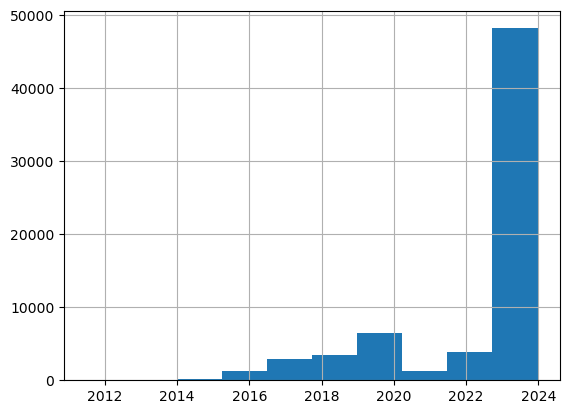

In [251]:
df['last_review'] = pd.to_datetime(df['last_review'])
date = datetime.strptime(date, "%Y-%m-%d")
df.last_review.hist()

In [252]:
df.last_review.isnull().value_counts()

last_review
False    67655
True     24123
Name: count, dtype: int64

In [253]:
"""
Converting review column to datetime, and selecting only the recently active listings. 
We also take Null values, because these might be new listings without reviews.
"""
df = df[(df['last_review'] > (date - relativedelta(years=1))) | (df['last_review'].isnull())]

print(f"Data frame after filtering last review date is {df.shape[0]:,} x {df.shape[1]}")

Data frame after filtering last review date is 70,872 x 75


Making the same cleaning as in the base file.

In [254]:
df[~(df.price.str.startswith('$', na=False))]
money = ['price']
for m in money:
    df[m] = df[m].str.replace(r'[$,]', '', regex=True).astype('float')
df_valid = df[~df['price'].isna()] # rows where price is valid

ints  = ['id', 'host_id', 'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews']

for i in ints:
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        #print("  - !!!Converting to unsigned 16-bit integer!!!")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

print(f"Data frame is {df_valid.shape[0]:,} x {df_valid.shape[1]}")

Data frame is 68,146 x 75


Looking for duplicates:

In [259]:
def find_duplicates(df_valid):
    """
    The function looks at hosts with multiple listings and checks if they are within 300m radius (150m max location scattering as per Airbnb's anonymisation algorithm, x2).
    It then estimates the number of genuine homes within the cluster.
    
    Returns a gdf with new columns: 
    'cluster_id' - each unique value is a cluster
    'easting', 'northing' - used in calculating the proximity of listings
    'prvt_rms_in_cluster','entr_hms_in_cluster' - summarises N of private rooms and entire homes within the cluster
    'genuine', 'true_nrooms' - boolean column, and int column, with the following assumptions:

    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded. 
    The location of the point will be amended to represent centrepoint of all rooms in the cluster.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home. 
    With the current timeframes, further enquiries into uniqueness of homes vs rooms inside each cluster is not feasible.
    """
    """
    We are looking for duplicates among multi-listing hosts. First, we filter by listings_count > 1.
    """
    finddups = df_valid[df_valid["host_listings_count"] > 1]
    print(f"There are {finddups.shape[0]} listings from multi-lister hosts")
    
    """
    I convert the df into gdf, reproject into EPSG 27700, and put easting and northing into new columns.
    """
    finddupsgdf = gpd.GeoDataFrame(finddups,
          geometry=gpd.points_from_xy(finddups.longitude, finddups.latitude, crs='epsg:4326'))
    
    finddupsgdf = finddupsgdf.set_crs('EPSG:4326', allow_override=True)
    finddups = finddupsgdf.to_crs('EPSG:27700', inplace=True)
    # print(finddupsgdf.crs)
    # finddupsgdf.plot()
    
    finddupsgdf['easting'] = finddupsgdf.geometry.x
    finddupsgdf['northing'] = finddupsgdf.geometry.y
    
    """
    I perform cluster analysis and mark listings from the same host that are within 300m from each other 
    (150m max location scattering as per Airbnb's anonymisation algorithm, x2). They constitute a cluster, and we then assess if they are a duplicate or not.
    The selected method computes pairwise distances  can calculate the distance matrix between all points in a group. 
    Before this method I tried KNN, but the listings were paired incorrectly. 
    cdist solved this, and it is relatively light on small groups (our dataset is large, but it is split into small groups - by host).
    """
    # Initialize a column for cluster IDs
    finddupsgdf['cluster_id'] = None
    
    # Process each host group
    for host_id, group in finddupsgdf.groupby("host_id"):
        if len(group) > 1:  # Only proceed if there is more than 1 listing
            coords = group[['easting', 'northing']].to_numpy()
            
            # Calculate pairwise distances using pdist (returns condensed distance matrix)
            dist_matrix = pdist(coords)
            
            # Perform hierarchical clustering using the condensed distance matrix
            linkage_matrix = linkage(dist_matrix, method='single')
            clusters = fcluster(linkage_matrix, t=300, criterion='distance')
            
            # Assign clusters back to the original GeoDataFrame
            finddupsgdf.loc[group.index, 'cluster_id'] = [f"{host_id}-{cluster}" for cluster in clusters]
        else:
            finddupsgdf.loc[group.index, 'cluster_id'] = None  # Single point, no clustering
    
    #creating gdf with clusters only
    finddupsgdf = finddupsgdf[~finddupsgdf['cluster_id'].isna()]
    finddupsgdf = finddupsgdf.loc[finddupsgdf.duplicated(subset='cluster_id', keep=False)]
    
    print(f"Found {len(set(finddupsgdf.cluster_id))} clusters with {len(finddupsgdf)} listings within these clusters.")
    
    """
    I calculate N of entire homes and rooms in each cluster.
    Limitation found during EDA: "bedrooms" column in InsideAirbnb differs between scrapes. 
    "2023-12-10" scrape has NaN values in this column, while "2024-09-06" scrape has full data.
    For both datasets, we use "beds" column as a substitute, because airbnb2024.bedrooms.median()/airbnb2024.beds.median() = 1
    """
    # Initialize the columns
    finddupsgdf['prvt_rms_in_cluster'] = None
    finddupsgdf['entr_hms_in_cluster'] = None
    
    # Loop through each cluster by cluster_id
    for i, group in finddupsgdf.groupby("cluster_id"):
        # Count number of entire homes and private rooms in the group
        n_entire_homes = group[group['room_type'] == 'Entire home/apt'].shape[0]
        n_private_rooms = group[group['room_type'] == 'Private room'].shape[0]
    
        # Assign these counts back to the original DataFrame
        finddupsgdf.loc[group.index, 'entr_hms_in_cluster'] = n_entire_homes
        finddupsgdf.loc[group.index, 'prvt_rms_in_cluster'] = n_private_rooms
    
    # null values in N of bedrooms will interfere with our analysis, therefore we drop them
    finddupsgdf = finddupsgdf[finddupsgdf.beds.notna()]
    print(f"Data frame after filtering bedrooms Nans is {len(finddupsgdf)} listings long")
    
    finddupsgdf['true_nrooms'] = finddupsgdf['beds'] #fill with these values for now
    for i, group in finddupsgdf.groupby("cluster_id"):
        # If there are no "Entire home/apt" listings, only rooms. We assume they combine into an entire home, or are a large-scale commercial let
        if (group['entr_hms_in_cluster'] == 0).any(): #using any because the values are the same within the group
            finddupsgdf.loc[group.index, 'true_nrooms'] = len(group)
    
    #finddupsgdf.true_nrooms.hist(range={1,10})
    
    print(f"There are {finddupsgdf[finddupsgdf['true_nrooms'] > 6].shape[0]} listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to {len(set(finddupsgdf[finddupsgdf['true_nrooms'] > 6].host_id))} unique host IDs.")
    """
    I then determine whether listings are genuine unique homes, or rooms from one entire home.
    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home
    """
    finddupsgdf['genuine'] = None
    
    for cluster_id, group in finddupsgdf.groupby("cluster_id"):
        num_entire_homes = (group['room_type'] == 'Entire home/apt').sum()
        
        if num_entire_homes == 0:
            # If only rooms are in the cluster
            finddupsgdf.loc[group.index, 'genuine'] = False  # Mark all as duplicates
            first_room_idx = group.index[0]  # Pick the first room as genuine
            finddupsgdf.loc[first_room_idx, 'genuine'] = True  # First room becomes the genuine home
            """ ... but the geometry is replaced with centroid x and y. 
            Without this the point and all associated rooms can be aggregated by different spatial unit, considering the scale of the location approximation (up to 150m from origin)"""
            dissolved_geometry = group.geometry.union_all()  # Combine all geometries in the group
            centroid = dissolved_geometry.centroid # Get the centroid of the combined geometry
            finddupsgdf.at[first_room_idx, 'geometry'] = Point(centroid.x, centroid.y)
        else:
            # Cluster has both rooms and entire homes
            finddupsgdf.loc[group.index, 'genuine'] = False  # Default all to duplicates
            entire_home_indices = group[group['room_type'] == 'Entire home/apt'].index
            finddupsgdf.loc[entire_home_indices, 'genuine'] = True  # Mark entire homes with true

    # write valid data to be used in further analysis
    # fn = {date}+"inside_airbnb_clean.csv"
    # path = os.path.join('data','inside_airbnb')
    
    # if not os.path.exists(path):
    #     print(f"Creating {path} under {os.getcwd()}")
    #     os.makedirs(path)
        
    # df_valid.to_file(os.path.join(path,fn), index=False)

    print(f"The clustering exercise identified {len(finddupsgdf[finddupsgdf['genuine'] == False])} listings that are potentially duplicates of other listings.")
    #print(f"The gdf has been saved into {path}")

    return finddupsgdf

In [260]:
df_valid_nodups = find_duplicates(df_valid)

There are 41847 listings from multi-lister hosts
Found 8629 clusters with 29253 listings within these clusters.
Data frame after filtering bedrooms Nans is 28874 listings long
There are 2065 listings that are within clusters with more than 6 listings in each. These are likely to be flats converted to holiday accommodation. We are leaving them in for the purpose of the exercise. They belong to 267 unique host IDs.
The clustering exercise identified 9121 listings that are potentially duplicates of other listings.


In [261]:
df_valid_nodups[['genuine']].value_counts()

genuine
True       19753
False       9121
Name: count, dtype: int64

We use samlples to test if the genuine==False listings are actually from one entire home.

In [297]:
# import matplotlib.pyplot as plt
# from io import BytesIO
# from PIL import Image
# import requests

# def check_genuine(df, random_state):
#     """
#     Receives df and random_state as args.
#     Displays the random ingenuine listing, and other listings from its cluster.
#     Shows image thumbnails for all listings in the cluster in a grid layout with clickable URLs above the images.
#     """
#     # Select a random "ingenuine" listing from the dataset
#     listing_check = df[df['genuine'] == False].sample(1, random_state=random_state)
    
#     print(f"Let's have a look at the random listing. ID: {listing_check.id.values[0]}")
#     print(f"Cluster number {listing_check.cluster_id.values[0]}")
#     print("All listings in this cluster:")
    
#     # Get all listings in the same cluster
#     same_cluster = df[df["cluster_id"] == listing_check.cluster_id.values[0]]
#     print(same_cluster[["id", "listing_url"]])
    
#     # Collect successful images and their associated URLs
#     successful_images = []
#     urls = []
    
#     for idx, row in same_cluster.iterrows():
#         try:
#             response = requests.get(row['picture_url'], timeout=10)
#             response.raise_for_status()  # Raise an error for HTTP issues
#             img = Image.open(BytesIO(response.content))
#             img.thumbnail((128, 128))  # Resize image for thumbnail display
#             successful_images.append(img)
#             urls.append(row['listing_url'])
#         except Exception as e:
#             print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")
    
#     # If no successful images, return early
#     if not successful_images:
#         print("No images could be retrieved.")
#         return
    
#     # Determine the number of rows and columns for the grid
#     num_images = len(successful_images)
#     grid_cols = 3
#     grid_rows = (num_images // grid_cols) + (1 if num_images % grid_cols != 0 else 0)
    
#     # Set up the subplots grid
#     fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, grid_rows * 4))
#     axes = axes.flatten()  # Flatten axes for easier iteration
    
#     # Display successful images with clickable URLs
#     for i, img in enumerate(successful_images):
#         axes[i].imshow(img)
#         axes[i].axis('off')  # Hide axes for a cleaner view of the image
#         # Display the clickable URL above the image
#         axes[i].set_title("")
#         plt.text(
#             0.5,
#             1.2,
#             urls[i],
#             ha='center',
#             va='bottom',
#             fontsize=8,
#             url=urls[i],
#             transform=axes[i].transAxes,
#             wrap=True
#         )
    
#     # Hide any unused axes
#     for j in range(len(successful_images), len(axes)):
#         axes[j].axis('off')
    
#     # Reduce gaps between images
#     plt.subplots_adjust(wspace=0.01, hspace=-0.4)  # Adjust horizontal and vertical spacing
#     plt.tight_layout(pad=0.2)  # Minimize overall padding around the grid
#     plt.show()

In [306]:
import base64  # Add this import at the top
import IPython.display as display

def check_genuine(df, random_state):
    """
    Receives df and random_state as args.
    Displays the random ingenuine listing, and other listings from its cluster.
    Shows image thumbnails for all listings in the cluster, with clickable URLs displayed above the images.
    """
    # Select a random "ingenuine" listing from the dataset
    listing_check = df[df['genuine'] == False].sample(1, random_state=random_state)
    
    print(f"Let's have a look at the random listing. ID: {listing_check.id.values[0]}")
    print(f"Cluster number {listing_check.cluster_id.values[0]}")
    print("All listings in this cluster:")
    
    # Get all listings in the same cluster
    same_cluster = df[df["cluster_id"] == listing_check.cluster_id.values[0]]
    # print(same_cluster[["id", "listing_url"]])
    
    # Collect successful images and their associated URLs
    successful_images = []
    urls = []
    
    for idx, row in same_cluster.iterrows():
        try:
            response = requests.get(row['picture_url'], timeout=10)
            response.raise_for_status()  # Raise an error for HTTP issues
            img = Image.open(BytesIO(response.content))
            img.thumbnail((190, 190))  # Resize image for thumbnail display
            successful_images.append((img, row['listing_url']))
        except Exception as e:
            print(f"Failed to retrieve image for Listing ID: {row['id']}. Error: {e}")
    
    # If no successful images, return early
    if not successful_images:
        print("No images could be retrieved.")
        return
    
    # Render images and clickable links in Quarto Markdown
    html_content = "<table>"
    for i, (img, url) in enumerate(successful_images):
        if i % 3 == 0:  # Start a new row every 3 images
            html_content += "<tr>"
        
        # Convert the image to a data URL
        img_buffer = BytesIO()
        img.save(img_buffer, format="PNG")
        img_data = img_buffer.getvalue()
        img_base64 = base64.b64encode(img_data).decode('utf-8')  # Encoding the image
        img_src = f"data:image/png;base64,{img_base64}"
        
        # Add the image and link to the HTML
        html_content += f"""
        <td style="text-align:center; padding:5px">
            <a href="{url}" target="_blank"><img src="{img_src}" style="width:128px; height:auto; border:1px solid #ccc" /></a>
        </td>
        """
        if i % 3 == 2:  # End the row every 3 images
            html_content += "</tr>"
    
    html_content += "</table>"
    
    # Display the HTML in Quarto
    display.display(display.HTML(html_content))

Let's have a look at the random listing. ID: 921062025308929659
Cluster number 74380759-1
All listings in this cluster:


,

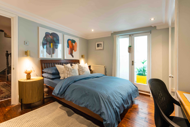
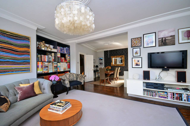

In [309]:
check_genuine(df_valid_nodups, 849375)

Let's have a look at the random listing. ID: 870267157425058201
Cluster number 143112490-1
All listings in this cluster:


,

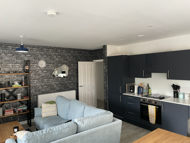
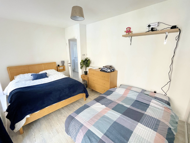

In [310]:
check_genuine(df_valid_nodups, 345)

Let's have a look at the random listing. ID: 1030301764808021556
Cluster number 527357185-1
All listings in this cluster:



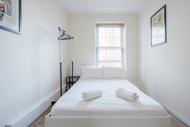
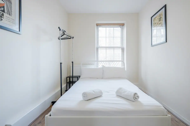
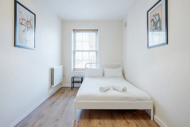
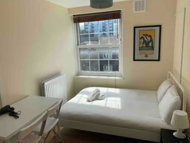
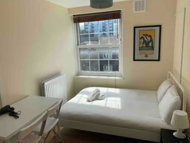
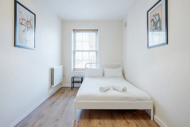
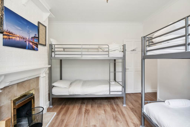
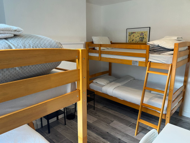
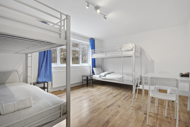
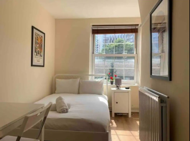
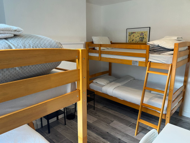
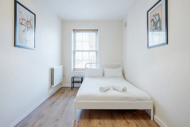
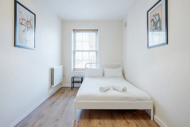

In [311]:
check_genuine(df_valid_nodups, 9)

Let's have a look at the random listing. ID: 24342366
Cluster number 63091616-1
All listings in this cluster:
Failed to retrieve image for Listing ID: 24342366. Error: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/0ddf4463-5401-4350-bda6-6478b61487f9.jpg
Failed to retrieve image for Listing ID: 38503545. Error: 403 Client Error: Forbidden for url: https://a0.muscache.com/pictures/f7920654-4a88-4fad-84c0-4a770a38d909.jpg


,,
,,
,,
,,

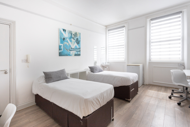
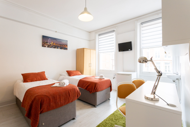
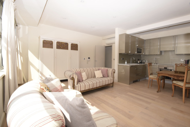
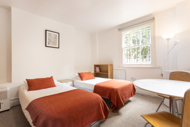
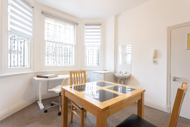
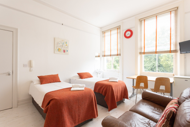
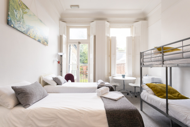
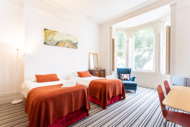
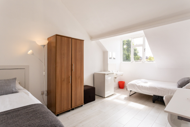
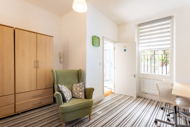
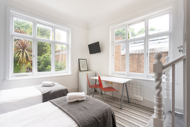
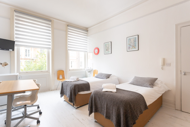

In [312]:
check_genuine(df_valid_nodups, 4567890)

Let's have a look at the random listing. ID: 19919528
Cluster number 59332669-1
All listings in this cluster:



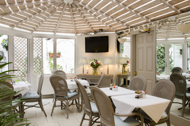
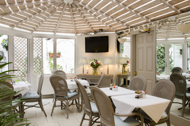
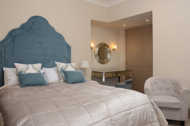
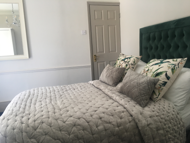

In [315]:
check_genuine(df_valid_nodups, 45576)

Let's have a look at the random listing. ID: 1040379427640923691
Cluster number 453130670-1
All listings in this cluster:



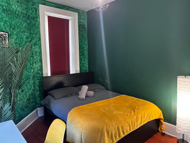
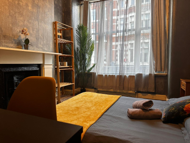
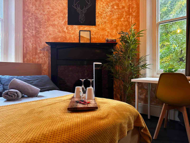
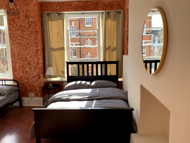
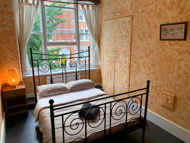

In [316]:
check_genuine(df_valid_nodups, 99999)

Let's have a look at the random listing. ID: 1566565
Cluster number 8332765-1
All listings in this cluster:


,

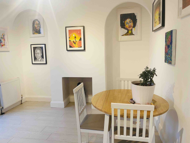
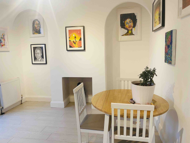

In [318]:
check_genuine(df_valid_nodups, 3456788)